In [1]:
! pip install transformers

In [2]:
from sklearn.cluster import KMeans
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [3]:
text = "https://worldlyhistory.com/sports-legacy-the-50-greatest-athletes-of-all-time?r=1#section-11"

In [4]:
import requests
from bs4 import BeautifulSoup
from transformers import pipeline

# Fetch the webpage content

response = requests.get(text)

# Parse the webpage
soup = BeautifulSoup(response.content, "html.parser")

# Extract text from the webpage
text = soup.get_text(separator="\n")  # Use newline as a separator for readability
print("Extracted Text (First 1000 characters):")
print(text[100:1000])  # Print the first characters to preview


Extracted Text (First 1000 characters):

Home
Privacy Policy
Terms
From Kelce to Curry: The 50 Greatest Athletes of All Time Ranked
In this comprehensive compilation, we spotlight the 50 greatest athletes of all time, spanning from the legendary prowess of Travis Kelce to the unparalleled skill of Stephen Curry. Our list celebrates the most iconic, influential, and famed figures in sports, encompassing champions from every professional league. Understanding the complexity of comparing athletes across diverse sports, each demanding unique skills and mental fortitude, our aim is to showcase the elite, the most accomplished, and the pinnacle performers in their respective fields.
When deliberating on who stands out as the ultimate athlete of all time, two critical considerations come to the forefront. The first is the athlete’s innate talent—an essential component given the rarity and significance of natural ability in the sports


In [5]:
chunks = text.split("\n")  # Split by newlines or use custom splitting logic

In [6]:
filtered_chunks = [c.strip() for c in chunks if c.strip()][:100]

In [7]:
embedder = pipeline("feature-extraction", model="distilbert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


In [8]:
# Filter out empty chunks and limit to a manageable number of chunks
filtered_chunks = [chunk.strip() for chunk in chunks if chunk.strip()][:100]

In [9]:
# Generate embeddings for filtered chunks
embeddings = np.array([embedder(chunk)[0][0] for chunk in filtered_chunks])

In [10]:
embeddings

array([[-0.28989592, -0.12918985, -0.24151243, ...,  0.06021313,
         0.41983581,  0.44474888],
       [-0.18809758, -0.0421017 ,  0.03696576, ..., -0.1675002 ,
         0.13952167,  0.44061762],
       [-0.10976576, -0.01895808, -0.30393723, ..., -0.15241194,
         0.08641158,  0.53272623],
       ...,
       [-0.26394302, -0.03015481, -0.04345171, ..., -0.09776367,
         0.19465427,  0.37612742],
       [-0.34937131, -0.07356682, -0.48065561, ...,  0.20721342,
         0.37090909,  0.1126643 ],
       [-0.06540211,  0.04215919,  0.04544913, ..., -0.10240402,
         0.16392088,  0.26358372]])

In [11]:
embeddings.shape

(36, 768)

In [12]:
batch_embeddings = embedder(filtered_chunks, batch_size=8)

In [13]:
embeddings_array = np.vstack([
    np.mean(np.array(chunk_emb), axis=0)
    for chunk_emb in batch_embeddings
])

In [14]:
max_K = min(10, embeddings_array.shape[0])   # or pick some other upper bound
inertias = []
for k in range(1, max_K+1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(embeddings_array)
    inertias.append(km.inertia_)

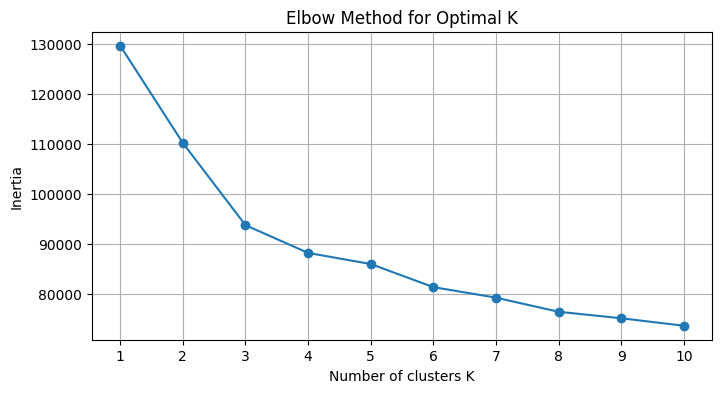

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_K+1), inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia")
plt.xticks(range(1, max_K+1))
plt.grid(True)
plt.show()

In [16]:
d1 = np.diff(inertias)      # Δ inertia
d2 = np.diff(d1)            # Δ² inertia
best_K = np.argmax(d2) + 2  # +2 corrects the offset (d2[0] is for K=1→2→3)

print(f"Automatically detected optimal K = {best_K}")

Automatically detected optimal K = 3


In [17]:
km_opt = KMeans(n_clusters=best_K, random_state=42, n_init=10)
labels = km_opt.fit_predict(embeddings_array)

In [18]:
for chunk, label in zip(filtered_chunks, labels):
    print(f"[Cluster {label}] {chunk}")

[Cluster 1] From Kelce to Curry: The 50 Greatest Athletes of All Time Ranked
[Cluster 2] Home
[Cluster 2] Privacy Policy
[Cluster 2] Terms
[Cluster 2] Home
[Cluster 1] Privacy Policy
[Cluster 2] Terms
[Cluster 2] From Kelce to Curry: The 50 Greatest Athletes of All Time Ranked
[Cluster 2] In this comprehensive compilation, we spotlight the 50 greatest athletes of all time, spanning from the legendary prowess of Travis Kelce to the unparalleled skill of Stephen Curry. Our list celebrates the most iconic, influential, and famed figures in sports, encompassing champions from every professional league. Understanding the complexity of comparing athletes across diverse sports, each demanding unique skills and mental fortitude, our aim is to showcase the elite, the most accomplished, and the pinnacle performers in their respective fields.
[Cluster 2] When deliberating on who stands out as the ultimate athlete of all time, two critical considerations come to the forefront. The first is the ath

In [19]:
optimal_clusters = best_K # Replace with the number of clusters you chose from the plot

# Run K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# Analyze the clusters (optional, but helpful for understanding)
print(f"\nClustering results with {optimal_clusters} clusters:")
for i in range(optimal_clusters):
    print(f"\nCluster {i+1}:")
    for j, text in enumerate(filtered_chunks):
        if clusters[j] == i:
            print(f"- {text}")


Clustering results with 3 clusters:

Cluster 1:
- Home
- Privacy Policy
- Terms
- Home
- Privacy Policy
- Terms
- fox
- Zinedine Zidane
- ADVERTISEMENT
- Tony Hawk
- ADVERTISEMENT
- esquire
- Fun Fact:
- ADVERTISEMENT
- Barry Sanders
- ADVERTISEMENT
- prideofdetroit
- ADVERTISEMENT

Cluster 2:
- From Kelce to Curry: The 50 Greatest Athletes of All Time Ranked
- From Kelce to Curry: The 50 Greatest Athletes of All Time Ranked
- In this comprehensive compilation, we spotlight the 50 greatest athletes of all time, spanning from the legendary prowess of Travis Kelce to the unparalleled skill of Stephen Curry. Our list celebrates the most iconic, influential, and famed figures in sports, encompassing champions from every professional league. Understanding the complexity of comparing athletes across diverse sports, each demanding unique skills and mental fortitude, our aim is to showcase the elite, the most accomplished, and the pinnacle performers in their respective fields.
- When deliber

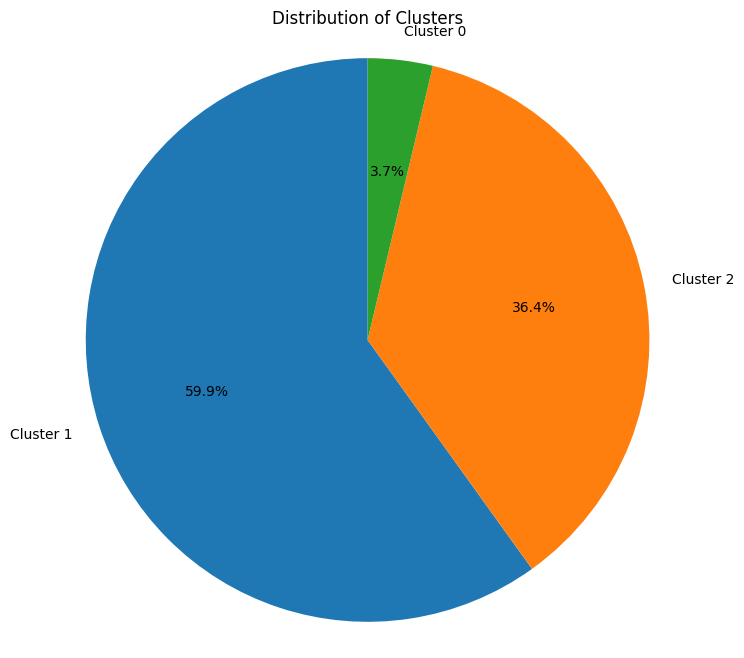

In [ ]:
import matplotlib.pyplot as plt

# Count the number of points in each cluster
cluster_counts = {}
for cluster in labels:
    cluster_counts[cluster] = cluster_counts.get(cluster, 0) + 1

# Create the pie chart
labels = [f"Cluster {cluster}" for cluster in cluster_counts.keys()]
sizes = list(cluster_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Clusters")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()